In [1]:
import numpy as np
import pandas as pd
from numpy import array

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
look_back =8
data=pd.read_csv('gold_train.csv')
dataset = np.asarray(data[['price']])
scaler = MinMaxScaler(feature_range=(0, 1))
x_sample = [200, 2000]
scaler.fit(np.array(x_sample)[:, np.newaxis])
#dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
trainx, testy = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train=scaler.transform(trainx)
test=scaler.transform(testy)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(len(testX),len(testY))

2158 2158


In [4]:
#Gru Model Declaration
batch_size = 16
model = Sequential()
model.add(GRU(25,activation='relu',input_shape=(look_back, 1)))
#model.add(Dropout(0.4))
model.add(Dense(4,activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)



In [5]:
%%time
history=model.fit(trainX, trainY, epochs=10, batch_size=batch_size,validation_data=(testX, testY), shuffle=False)

Train on 8653 samples, validate on 2158 samples
Epoch 1/10
8653/8653 [==============================] - 24s 3ms/step - loss: 5.8672e-04 - val_loss: 0.0040
Epoch 2/10
8653/8653 [==============================] - 22s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/10
8653/8653 [==============================] - 22s 3ms/step - loss: 3.4599e-04 - val_loss: 2.1520e-04
Epoch 4/10
8653/8653 [==============================] - 22s 3ms/step - loss: 8.7201e-05 - val_loss: 1.3955e-04
Epoch 5/10
8653/8653 [==============================] - 22s 3ms/step - loss: 2.8053e-05 - val_loss: 1.1078e-04
Epoch 6/10
8653/8653 [==============================] - 22s 3ms/step - loss: 2.7249e-05 - val_loss: 1.6875e-04
Epoch 7/10
8653/8653 [==============================] - 22s 3ms/step - loss: 2.9805e-05 - val_loss: 1.9573e-04
Epoch 8/10
8653/8653 [==============================] - 22s 3ms/step - loss: 3.3788e-05 - val_loss: 2.8136e-04
Epoch 9/10
8653/8653 [==============================] - 23s 3ms/step - loss:

In [6]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
#print(testX[:252])
print('Test Score: ', testScore)

Train Score:  0.0017435478951193682
Test Score:  0.00042762767657286086


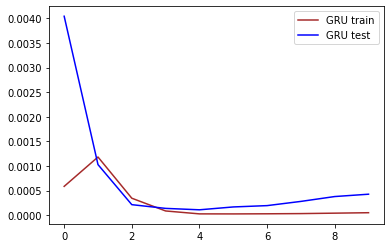

In [7]:
plt.plot(history.history['loss'], label='GRU train', color='brown')
plt.plot(history.history['val_loss'], label='GRU test', color='blue')
plt.legend()
plt.show()

In [8]:
input=test[test_size-look_back:]
r_data=pd.read_csv('gold_july.csv').values
size=r_data.size
predicted_y=[]
for i in range(size):
    #print(input)
    input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
    input_lstm=np.reshape(input_lstm, (1,look_back,1))
    #print(input_lstm)
    y=model.predict(input_lstm,verbose=0)
    #print(y)
    input=np.append(input,y[0])
    y=scaler.inverse_transform(y)
    predicted_y.append(y[0])
    #print(predicted_y)
    #i=i+1

#print(scaler.transform(r_data))

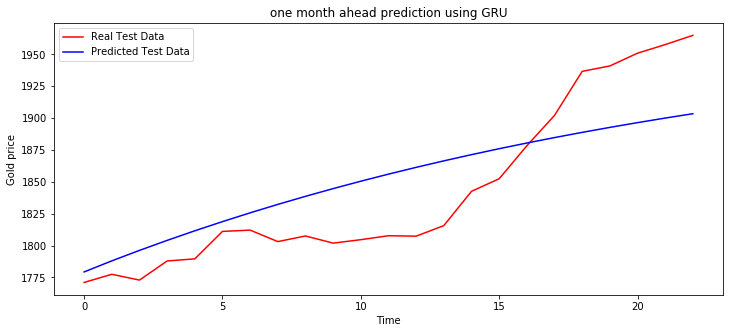

In [9]:
plt.figure(figsize=(12,5))
plt.plot(r_data, color = 'red', label = 'Real Test Data')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Test Data')
plt.title('one month ahead prediction using GRU')
plt.xlabel('Time')
plt.ylabel('Gold price')
plt.legend()
plt.show()


In [10]:
input=test[test_size-look_back:]
r_data=pd.read_csv('gold_july.csv').values
size=r_data.size
predicted_1y=[]
for i in range(size):
    #print(input)
    input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
    input_lstm=np.reshape(input_lstm, (1,look_back,1))
    #print(input_lstm)
    y=model.predict(input_lstm,verbose=0)
    #print(y)
    x=scaler.transform([r_data[i]])
    input=np.append(input,x)
    y=scaler.inverse_transform(y)
    predicted_1y.append(y[0])
    #print(predicted_y)
    #i=i+1

#print(scaler.transform(r_data))

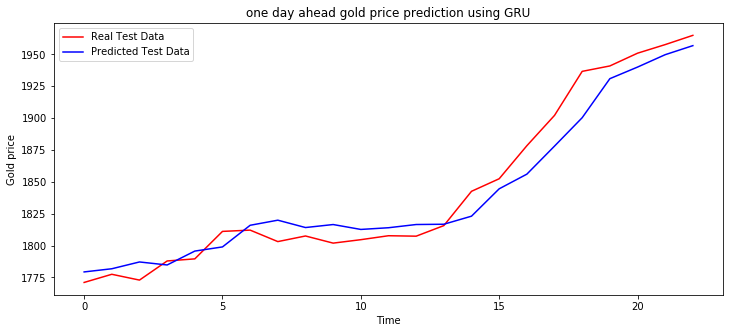

In [11]:
plt.figure(figsize=(12,5))
plt.plot(r_data, color = 'red', label = 'Real Test Data')
plt.plot(predicted_1y, color = 'blue', label = 'Predicted Test Data')
plt.title('one day ahead gold price prediction using GRU')
plt.xlabel('Time')
plt.ylabel('Gold price')
plt.legend()
plt.show()

In [12]:
import pickle
filename = 'GRU_gold.sav'
pickle.dump(model, open(filename, 'wb'))